### Try infering a typical radious  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from matplotlib_scalebar.scalebar import ScaleBar
from microfilm.colorify import multichannel_to_rgb

from scipy.special import gammaln

from bayes_coloc.continuous_donut_interaction import DonutInteraction
from bayes_coloc.plot_matching_lines import plot_pair_prob
from bayes_coloc.blob_detection_wraper import blob_detection



In [2]:
# First we read some example images

file_A = os.path.join('data', 'channel_A_setting_4.tif')
file_B = os.path.join('data', 'channel_B_setting_4.tif')

l = 400
area = l**2
xlim_roi = [0, 0+l]
ylim_roi = [0, 0+l]
image_A = io.imread(file_A)
image_B = io.imread(file_B)


# We now can perform a point detection
x = blob_detection(image_A)
y = blob_detection(image_B)

data_file = os.path.join('data', 'true_params_setting_4.npy')
true_params = np.load(data_file, allow_pickle=True).item()
n_gamma = true_params['n_gamma']


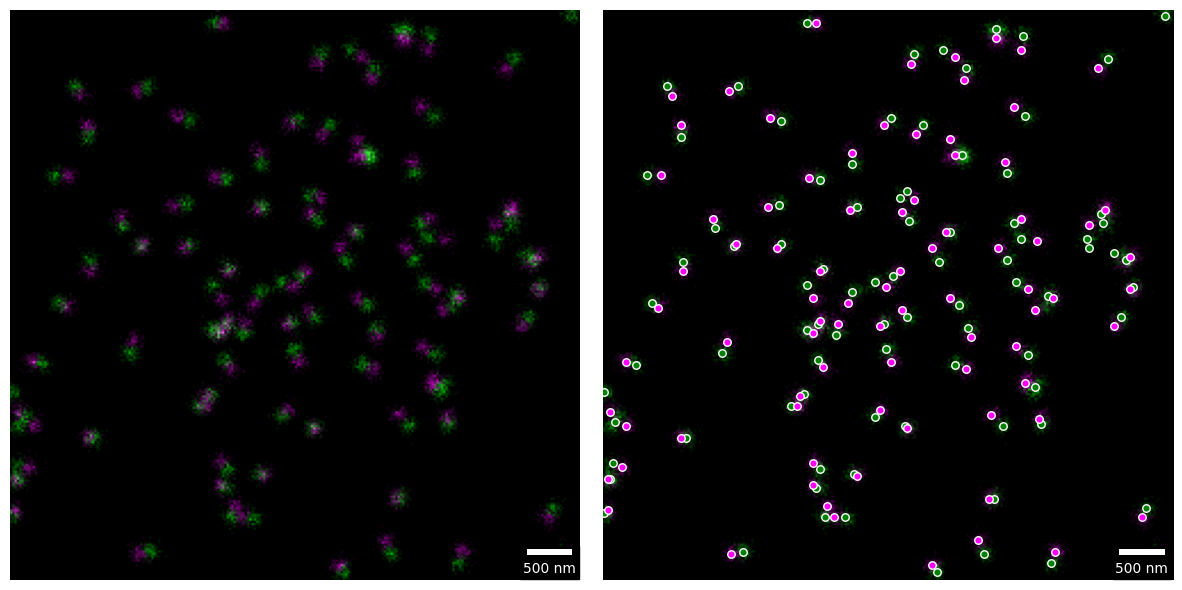

In [3]:
out = multichannel_to_rgb(images=[image_A, image_B], cmaps=['pure_green', 'pure_magenta'])
background_image = out[0]
# plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot without scatter plots
ax1.imshow(background_image)
ax1.axis("off")
scalebar1 = ScaleBar(0.04, "nm", length_fraction=0.10, box_color="black", color="white", location="lower right")
scalebar1.dx = 25
ax1.add_artist(scalebar1)

# Plot with scatter plots
ax2.imshow(background_image)
ax2.axis("off")
ax2.scatter(x[:, 0], x[:, 1], c="green", s=29, edgecolors="white", zorder=3)
ax2.scatter(y[:, 0], y[:, 1], c="magenta", s=29, edgecolors="white", zorder=3)
scalebar2 = ScaleBar(0.04, "nm", length_fraction=0.10, box_color="black", color="white", location="lower right")
scalebar2.dx = 25
ax2.add_artist(scalebar2)

plt.tight_layout()
plt.show()


In [10]:
# define proposal, prior and starting parameters
scale_interval = [0, 6]
radius_interval = [0, 6]
area = image_A.shape[0]*image_A.shape[1]
hyper_theta = len(x)/2


    
def log_prior(params):
    """ Defines a log prior for the parameters of the model (up to a constant)"""
    
    alpha = params["alpha"]
    gamma = params['gamma']
    beta = params["beta"]
    radius = params['radius']
    scale = params['scale']
    
    # hyperparameters
    k = 1
    theta = hyper_theta
    def ld_gamma(x, k, theta):  
        a = k
        b = 1/theta
        if x <= 0:
            return -np.inf
        else:
            return a*np.log(b) - gammaln(a) + (a-1)*np.log(x) - b*x


    # check if lam parameters are valid
    log_prob = 0
    
    log_prob += ld_gamma(alpha, k, theta)
    log_prob += ld_gamma(gamma, k, theta)
    log_prob += ld_gamma(beta, k, theta)
    
    if scale_interval[0] < scale < scale_interval[1]:
        log_prob += 0
    else:
        log_prob = -np.inf
    if radius_interval[0] < radius < radius_interval[1]:
        log_prob += 0
    else:
        log_prob = -np.inf
    return log_prob

def proposal(params):
    """ Defines a proposal for the parameters of the model """
    scale_temp = 0.1
    radius_temp = 0.1
    intensity_temp = 2
    
    scale = params['scale']
    radius = params['radius']
    alpha = params["alpha"]
    gamma = params['gamma']
    beta = params["beta"]
    
    # new proposal for the scale
    scale_new = scale + np.random.normal(scale=scale_temp)
    new_radius = radius + np.random.normal(scale=radius_temp)
    
    # new proposal for the intensities
    alpha_new = alpha + np.random.normal(scale=intensity_temp)
    beta_new = beta + np.random.normal(scale=intensity_temp)
    gamma_new = gamma + np.random.normal(scale=intensity_temp)
    
    return {"alpha": alpha_new, "beta": beta_new, "gamma": gamma_new, "scale": scale_new, "radius":new_radius, "area":area}


start_params = {"alpha": hyper_theta, "beta": hyper_theta, "gamma": hyper_theta,
                "scale": 2, "radius":2, "area":area}
    


In [11]:

print(len(x), len(y))
swap_params = start_params.copy()

# setting parameters for the swap proposal
swap_params["scale"] = 9
swap_params["radius"] = 1

np.random.seed(0)
chain = DonutInteraction(x, y,start_params, swap_params, log_prior, proposal)

88 85


In [12]:
chain.run(n_samples=50000, burn_in=0)
print(len(chain.param_trajectory))

Burn-in period: 0it [00:00, ?it/s]
Sampling:   0%|          | 0/50000 [00:00<?, ?it/s]

Sampling: 100%|██████████| 50000/50000 [02:41<00:00, 310.12it/s]

50002


In [13]:
chain.latent_acceptance_rate

0.09772

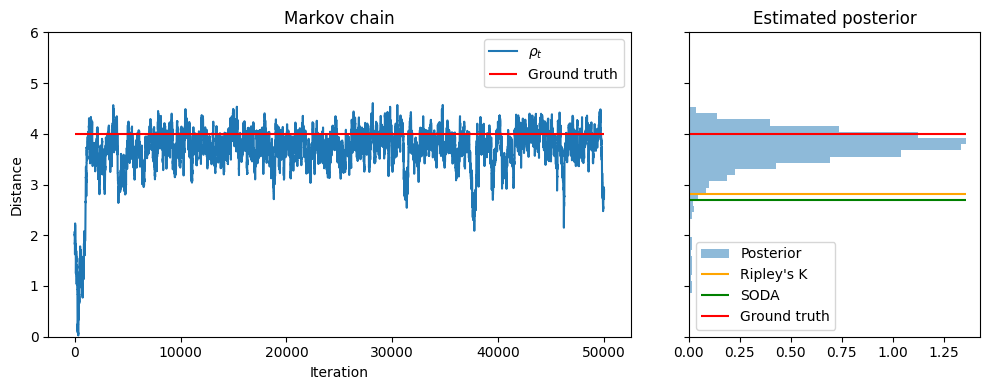

In [15]:
# do plot for radius parameter
ripley_dist = 2.82
soda_dist = 2.69
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
# fig.suptitle("Co-localization distance")# , fontsize=16)
ax[0].set_ylim(radius_interval)
ax[1].set_visible(False)

radius_trajectory = [params["radius"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(radius_trajectory)), radius_trajectory, label=r'$\rho_t$')
ax[0].set_xlabel("Iteration")
ax[0].set
ax[0].set_ylabel("Distance")
ax[0].hlines(y=true_params["radius"], xmin=0, xmax=len(radius_trajectory), color="red", label="Ground truth")
# ax[0].hlines(y=ripley_val_radius, xmin=0, xmax=len(radius_trajectory), color="red", label="Ripley value")
ax[0].legend()
ax[0].set_title("Markov chain")

bins = np.linspace(radius_interval[0], radius_interval[1], 50)
ax[2].set_title("Estimated posterior")
ax[2].hist(radius_trajectory, bins=bins, alpha=0.5, label="Posterior", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(radius_trajectory, bins=bins, density=True)[0])
ax[2].hlines(y=ripley_dist, xmin=0, xmax=xmax, color="orange", label="Ripley's K")
ax[2].hlines(y=soda_dist, xmin=0, xmax=xmax, color="green", label="SODA")
ax[2].hlines(y=true_params["radius"], xmin=0, xmax=xmax, color="red", label="Ground truth")
ax[2].set_ylim(radius_interval)
ax[2].set_yticklabels([])
ax[2].legend()
plt.tight_layout()
plt.savefig("plots/setting_4_rho.png", dpi=400)
plt.show()


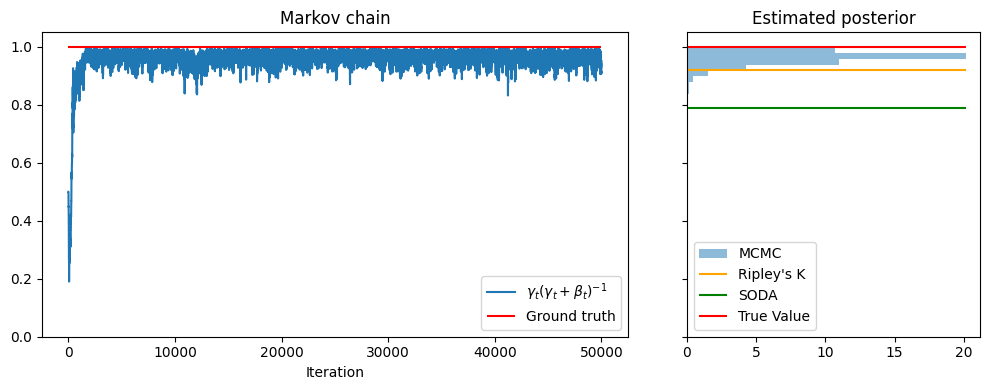

In [16]:
# probability of pairing in the second channel
ripley_percent = 0.92
soda_percent = 0.79
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
# fig.suptitle("Percentage of co-localized markers in channel 2")# , fontsize=16)
ax[0].set_ylim((0, 1.05))
ax[0].set_title("Markov chain")
ax[0].set_xlabel("Iteration")

ax[1].set_visible(False)
p_b_pair_traj = [params["gamma"]/(params["gamma"]+params["beta"]) for params in chain.param_trajectory]
p_b_pair_true = true_params["gamma"]/(true_params["gamma"] + true_params["beta"])
ax[0].plot(np.arange(len(p_b_pair_traj)), p_b_pair_traj, label=r'$\gamma_t(\gamma_t + \beta_t)^{-1}$')
ax[0].hlines(y=p_b_pair_true, xmin=0, xmax=len(p_b_pair_traj), color="red", label="Ground truth")
ax[0].legend()
bins = np.linspace(0, 1, 50)
ax[2].hist(p_b_pair_traj, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(p_b_pair_traj, bins=bins, density=True)[0])
ax[2].hlines(y=ripley_percent, xmin=0, xmax=xmax, color="orange", label="Ripley's K")
ax[2].hlines(y=soda_percent, xmin=0, xmax=xmax, color="green", label="SODA")
ax[2].hlines(y=true_params["radius"], xmin=0, xmax=xmax, color="red", label="True Value")
ax[2].hlines(y=p_b_pair_true, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, 1.05))
ax[2].set_title("Estimated posterior")

ax[2].set_yticklabels([])
ax[2].legend()
plt.tight_layout()
plt.savefig("plots/setting_4_percentage.png", dpi=400)
plt.show()



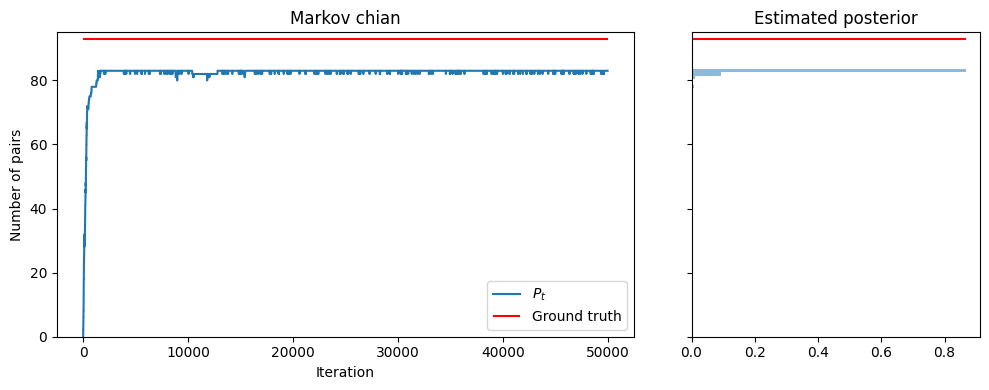

In [17]:
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
# set title of the plot 
# fig.suptitle("Number of co-localized markers")
nx = len(x)
ny = len(y)
n_max = np.minimum(nx, ny)


ax[1].set_visible(False)

pair_count = chain.pair_count_trajectory
ax[0].plot(np.arange(len(pair_count)), pair_count, label="$P_t$")
ax[0].set_ylim((0, n_max+10))
ax[0].hlines(y=n_gamma, xmin=0, xmax=len(pair_count), color="red", label="Ground truth")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Number of pairs")
ax[0].legend()
ax[0].set_title("Markov chian")
bins = np.arange(n_max+2)-0.5
ax[2].hist(chain.pair_count_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           orientation="horizontal", color="tab:blue", density=True)
xmax = np.max(np.histogram(pair_count, bins=bins, density=True)[0])
ax[2].hlines(y=n_gamma, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, n_max+10))
ax[2].set_yticklabels([])
ax[2].set_title("Estimated posterior")
plt.tight_layout()
plt.savefig("plots/setting_4_pair_count.png", dpi=400)
plt.show()



[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.99596008 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


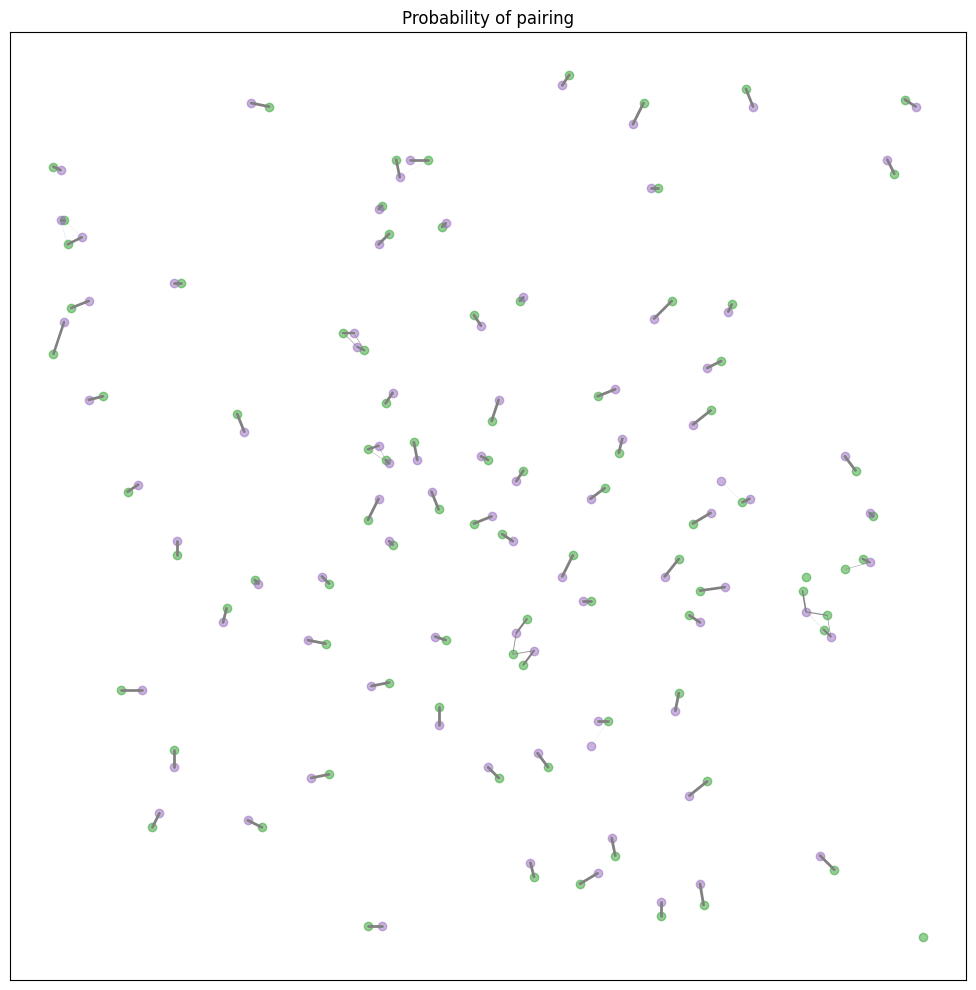

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
marker = "o"
alpha = 0.5
linewidth = 2

ax.set_aspect("equal")

# remove ticks
ax.set_xticks([])
ax.set_yticks([])


plot_pair_prob(x, y, chain.pairing_probabilities(), ax=ax, l=linewidth, scatter_alpha=alpha)
ax.set_title("Probability of pairing")
# thight layout
plt.tight_layout()

plt.show()
